# TP 1 : Indicateurs Intraday et relations entre des variables journalières

### By Zhiyuan XU, Wenjun LIU


Le but de ce TP est de se failiariser avec `pandas` et les bases de données et de construire les courbes intraday de certains indicateurs de marché tels que le volume, le nombre de trades, la volatilité, le spread, l'imbalance ou encore la liquidité disponible au meilleures limites (best bid et best ask). 

## I. Importation et lecture des données

Importer les librairies Python nécessaire.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pylab as plt
from datetime import datetime
import statsmodels.api as sm

Importation des données.

In [2]:
# Exemple pour importer les données de Google
df_trades  = pd.read_hdf('Data/GOOGLE.h5')

Afficher les 10 premières lignes du `DataFrame`:

In [3]:
df_trades.head(10)

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign
Time,,,,,,,
2011-01-03 09:30:01.846,597.29,181,597.29,597.39,100,100,-1
2011-01-03 09:30:01.862,597.39,100,596.23,597.49,100,100,0
2011-01-03 09:30:02.492,597.19,100,596.78,597.49,100,100,0
2011-01-03 09:30:02.718,597.19,100,596.78,597.49,100,100,0
2011-01-03 09:30:03.274,597.19,100,596.78,597.49,100,1400,0
2011-01-03 09:30:03.500,597.18,400,596.78,597.49,100,1400,0
2011-01-03 09:30:03.704,597.05,100,597.03,597.14,100,200,0
2011-01-03 09:30:03.918,597.14,100,597.03,597.14,100,100,1
2011-01-03 09:30:03.994,597.07,100,597.03,597.49,100,1400,0


Chaque `DataFrame` présente l'ensemble des transactions pour l'année 2011 pour l'actif et a le même format : 
* l'index `Time` est le timestamp de la transaction ;
* la colonne `TradedPrice` représente le prix moyen par action de la transaction ;
* la colonne `TradedQty` représente le volume de la transaction ;
* la colonne `BidPrice` représente le prix du best bid juste avant la transaction ;
* la colonne `AskPrice` représente le prix du best ask juste avant la transaction ;
* la colonne `BidQty` représente le volume au best bid juste avant la transaction ;
* la colonne `AskQty` représente le volume au best ask juste avant la transaction ;
* la colonne `TradedSign` représente le signe de la transaction (négatif pour Bid et positif pour ask).

L'index `Time` de la série temporelle est au format `Python`. Vous pouvez donc extraire les dates, mais aussi l'année, le mois, le jour, l'heure, la minute, etc.

In [4]:
df_trades.index.date # date de l'index
df_trades.index.year # année de l'index
df_trades.index.month # mois de l'index
df_trades.index.day # jour de l'index
df_trades.index.hour # heure de l'index
df_trades.index.minute # minute de l'index
df_trades.index.second # seconde de l'index

Int64Index([ 1,  1,  2,  2,  3,  3,  3,  3,  3,  5,
            ...
            53, 53, 55, 55, 55, 56, 56, 56, 57, 57],
           dtype='int64', name='Time', length=1578797)

## II. Graphiques des différents indicateurs intraday

### 1. Courbes de volume en % pour comparer les différents actifs

On va calculer la courbe de volume par tranche de 5 minutes pour chaque jour, puis en faire la moyenne sur l'année (pour chacun des 10 actifs).

Pour faire la courbe sur une journée, vous pouvez utiliser la fonction `resample` de `pandas` en définissant la fréquence à 5 minutes. Cette fonction permet de calculer pour une fréquence donnée des fonctions simple d'une série temporelle (comme la somme, moyenne, variance, minimum, maximum, etc.).

In [5]:
from tqdm.notebook import trange, tqdm
from matplotlib.dates import DateFormatter

In [6]:
allstocks = {
    0:['CANON', 'PANASONIC', 'SONY'],
    1:['AMAZON', 'APPLE', 'GOOGLE'],
    2:['SANOFI', 'BOUYGUES', 'LVMH', "TOTAL"],
}
date_form = DateFormatter("%H:%M")

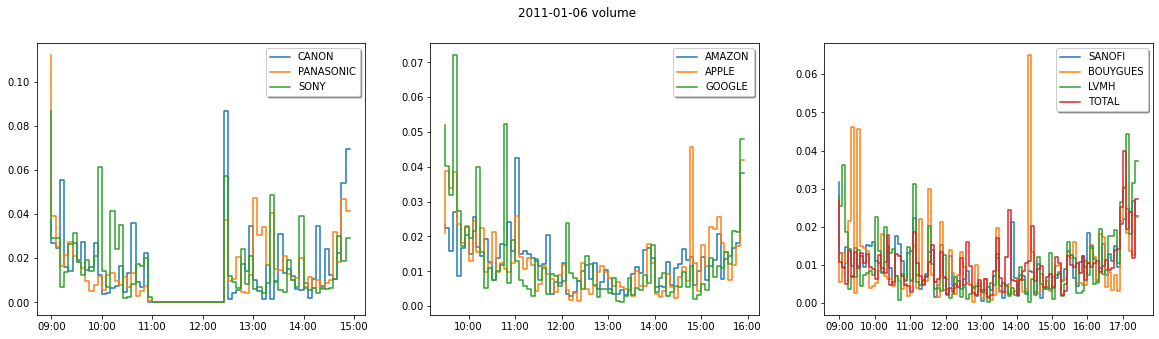

In [7]:
def plot_by(names_dict, day):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    
    for i, name_list in tqdm(names_dict.items()):
        for name in name_list:
            df_trades  = pd.read_hdf(f'Data/{name}.h5').loc[:, ["TradedQty"]]
            
            df_trades_day = df_trades.groupby([df_trades.index.date]).get_group(day)
            
            axs[i].plot(df_trades_day.groupby(pd.Grouper(freq='5Min')).TradedQty.sum()/df_trades_day.TradedQty.sum(), 
                        label=f'{name}', drawstyle='steps-pre')
            axs[i].legend(shadow=True, fancybox=True)
            axs[i].xaxis.set_major_formatter(date_form)
    fig.suptitle(f"{day} volume")
    plt.show()
plot_by(allstocks, "2011-01-06")

```
Commentaires: 
Les graphes par jour varient d'un jour à l'autre, mais ils ont tous la même tendances, haute volume a l'ouverture et la fermeture, pour la bourse de Paris, volume tres haut vers 11h30, 14h30 et 15h30, quand il y a des évènements important qui arrivent.

On trace ensuite les graphes moyenne sur toute l'annee pour les meme horaires
```

In [8]:
# open times and close time in each markets
open_times = ["2011-01-01 09:00", "2011-01-01 09:30", "2011-01-01 09:00"]
close_times = ["2011-01-01 15:00", "2011-01-01 16:00", "2011-01-01 17:30"]

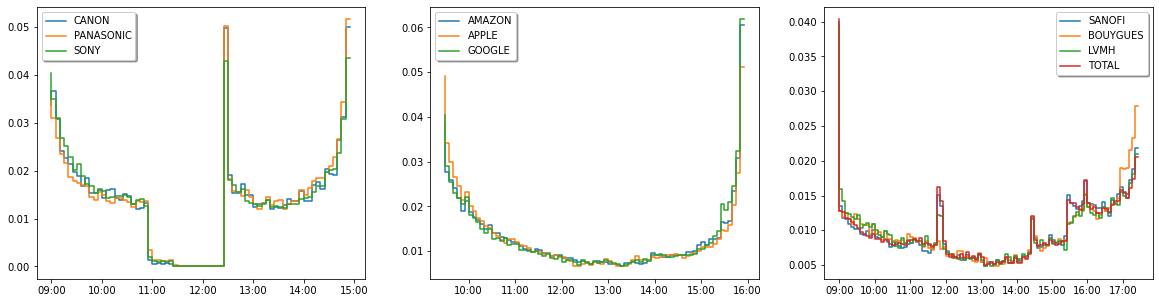

In [9]:
# les moyennes sur toute l'annee:
def plot_mean_per_year():
    f, axs = plt.subplots(1, 3, figsize=(20,5))
    for k, stocks in tqdm(allstocks.items()):
        for stock in stocks:
            df_trades = pd.read_hdf(f'Data/{stock}.h5').loc[:, ["TradedQty"]]
            df_trades_gb = df_trades.groupby(pd.Grouper(freq='5Min')).sum()
            times = df_trades_gb.index
            index = pd.date_range(open_times[k], end=close_times[k], closed='left', freq="5Min")
            df_trades_mean_by_year = df_trades_gb.groupby([times.hour, times.minute]).sum()
            np_trades_mean_by_year = np.zeros(shape=len(index))
            tot = df_trades.TradedQty.sum()
            for i, t in enumerate(index):
                np_trades_mean_by_year[i] = df_trades_mean_by_year.loc[(t.hour, t.minute), "TradedQty"] / tot
            axs[k].plot(index, np_trades_mean_by_year, label=f'{stock}', drawstyle='steps')
            
            axs[k].xaxis.set_major_formatter(date_form)
            axs[k].legend(shadow=True, fancybox=True)
    plt.show()
plot_mean_per_year()

Commenter les résultats obtenus.
```
Les tendances par jour sont devenues plus claires: la forme de "U" pour la bourse americaine, et haut volume à l'ouverture et la fermeture. En particulier, des piques dans la journée pour la bourse francaise: vers 11h30 souvent suite aux annonces BCE, la pique de 15:30 correspond aux l'ouverture des marches americains.
```

### 2. Autres indicateurs à représenter

En plus des courbes de volumes précédentes (toujours par tranche de 5 minutes et pour chaque actif), il faut faire et commenter les graphiques suivants (en renormalisant pour pouvoir comparer les différents actifs)


* Nombre de trades ;


* Turnover (cash) ;


* Spread moyen ; 


* Volatilité ;


* Imbalance : $|Q_{ask}-Q_{bid}|/(Q_{ask}+Q_{bid})$ ;


* Quantités aux best limits ($Q_{ask}+Q_{bid}$).

### Reponse: 
* Nombre de trades

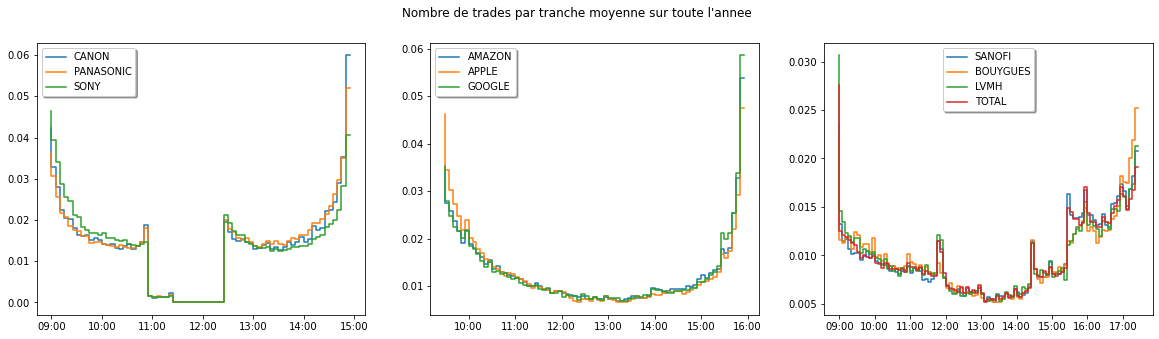

In [10]:
f, axs = plt.subplots(1, 3, figsize=(20,5))
f.suptitle("Nombre de trades par tranche moyenne sur toute l'annee")
for k, stocks in tqdm(allstocks.items()):
    # variables for this zone:
    index = pd.date_range(open_times[k], end=close_times[k], closed='left', freq="5Min")
    for stock in stocks:
        np_trades_mean_by_year = np.zeros(shape=index.shape[0])
        df_trades = pd.read_hdf(f'Data/{stock}.h5').loc[:, ['TradedQty']]
        df_trades.loc[:, 'date'] = df_trades.index.date
        
        df_trades = df_trades.reset_index().set_index(keys=['date', 'Time'])
        cnt = 0
        for date, df_trades_date in df_trades.groupby(level=0):
            df_trades_date = df_trades_date.droplevel(0).groupby(pd.Grouper(freq='5min')).count()
            qty_tot = df_trades_date.TradedQty.sum()
            if df_trades_date.shape[0] != np_trades_mean_by_year.shape[0]:
                continue
            cnt += 1
            for i in range(len(index)):
                np_trades_mean_by_year[i] += df_trades_date.iloc[i, 0] / qty_tot
        np_trades_mean_by_year /= cnt
        axs[k].plot(index, np_trades_mean_by_year, label=f'{stock}', drawstyle='steps')
        axs[k].xaxis.set_major_formatter(date_form)
        axs[k].legend(shadow=True, fancybox=True)
plt.show()

```
la forme du nombre de trades est très similaire au celui de volume, on va voit qu'il y a en effet une relation tres lineaire entre ces deux quantites.
```

* Turnover (cash) ;

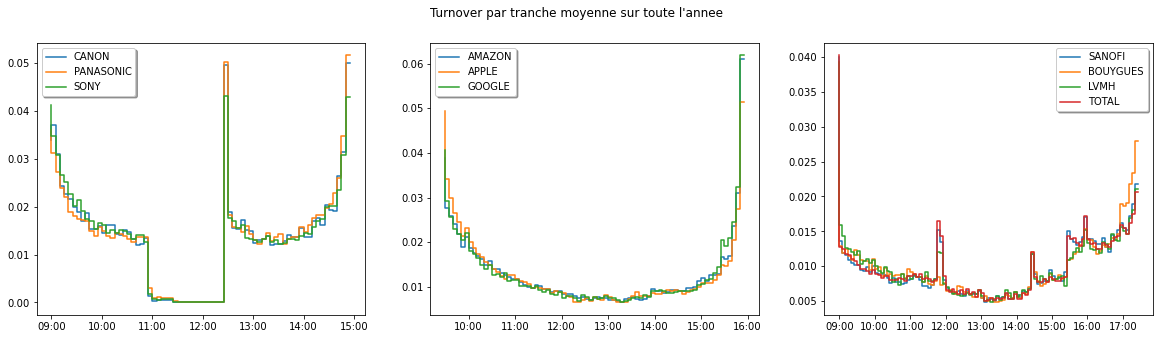

In [47]:
f, axs = plt.subplots(1, 3, figsize=(20,5))
f.suptitle("Turnover par tranche moyenne sur toute l'annee")
for k, stocks in tqdm(allstocks.items()):
    # variables for this zone:
    index = pd.date_range(open_times[k], end=close_times[k], closed='left', freq="5Min")
    for stock in stocks:
        df_trades = pd.read_hdf(f'Data/{stock}.h5')
        df_trades.loc[:, "Turnover"] = df_trades.TradedPrice * df_trades.TradedQty
        df_trades_gb = df_trades.groupby(pd.Grouper(freq='5Min')).sum()
        tot = df_trades_gb.loc[:, "Turnover"].sum()
        times = df_trades_gb.index
        df_trades_mean_by_year = df_trades_gb.groupby([times.hour, times.minute]).sum()
        np_trades_mean_by_year = np.zeros(shape=len(index))
        for i, t in enumerate(index):
            np_trades_mean_by_year[i] = df_trades_mean_by_year.loc[(t.hour, t.minute), 'Turnover'] / tot
        axs[k].plot(index, np_trades_mean_by_year, label=f'{stock}', drawstyle='steps')
        axs[k].xaxis.set_major_formatter(date_form)
        axs[k].legend(shadow=True, fancybox=True)
plt.show()

```
On constate que la forme du turnover est aussi similaire au celui du volume et du nombre de trades, de forme "U".
```

* Spread moyen

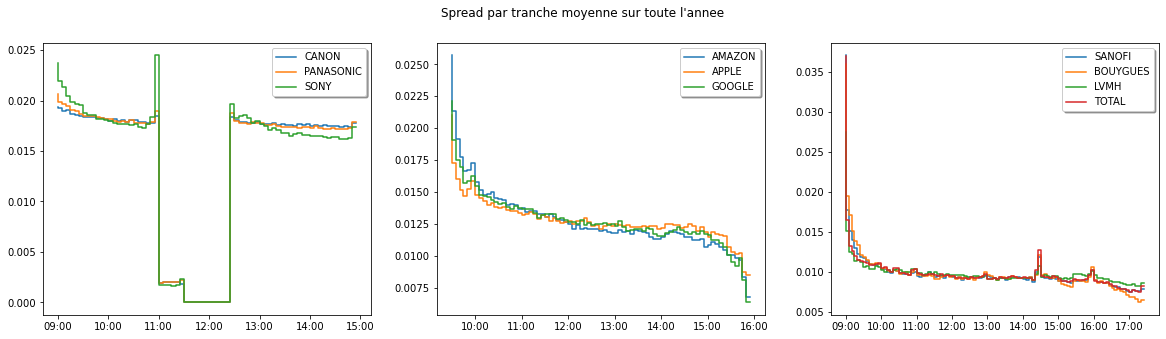

In [12]:
f, axs = plt.subplots(1, 3, figsize=(20,5))
f.suptitle("Spread par tranche moyenne sur toute l'annee")
for k, stocks in tqdm(allstocks.items()):
    index = pd.date_range(open_times[k], end=close_times[k], closed='left', freq="5Min")
    for stock in stocks:
        df_trades = pd.read_hdf(f'Data/{stock}.h5')
        df_trades.loc[:, "SpreadMoyen"] = df_trades.AskPrice - df_trades.BidPrice
        
        df_trades_gb = df_trades.groupby(pd.Grouper(freq='5Min')).mean()
        tot = df_trades_gb.loc[:, "SpreadMoyen"].sum()
        times = df_trades_gb.index
        df_trades_mean_by_year = df_trades_gb.groupby([times.hour, times.minute]).sum()
        np_trades_mean_by_year = np.zeros(shape=len(index))
        for i, t in enumerate(index):
            np_trades_mean_by_year[i] = df_trades_mean_by_year.loc[(t.hour, t.minute), 'SpreadMoyen'] / tot
        axs[k].plot(index, np_trades_mean_by_year, label=f'{stock}', drawstyle='steps')
        axs[k].xaxis.set_major_formatter(date_form)
        axs[k].legend(shadow=True, fancybox=True)
plt.show()

```
On reconnait la forme 'S' du spread aux marchés americains et Parisien, ce qui est raisonnable: le spread diminue quand l'information est disponible au fur et à mesure des trades. Pour le bourse de Paris, des piques dans la journée sont due aux ouvetures des marches étrangers (americain). Pour le marché japonais, la forme 'S' n'est pas très claire à cause de la rouverture à 12:30é 
```

* Volatility

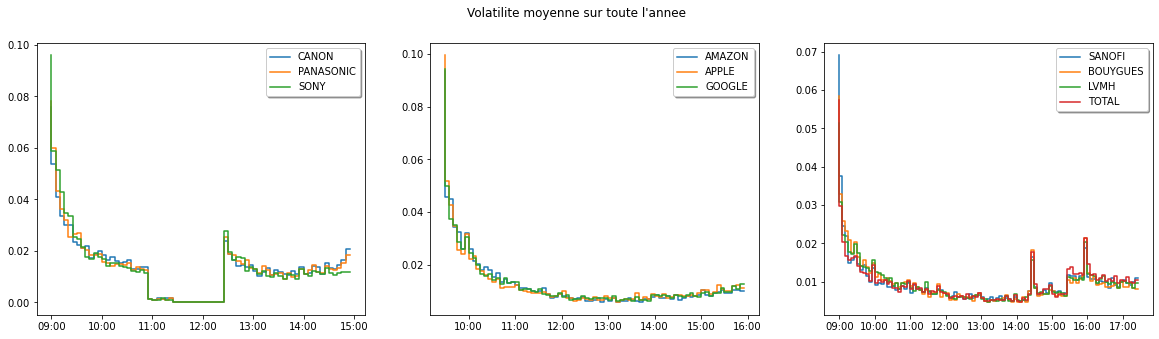

In [11]:
f, axs = plt.subplots(1, 3, figsize=(20,5))
f.suptitle("Volatilite moyenne sur toute l'annee")
for k, stocks in tqdm(allstocks.items()):
    # variables for this zone:
    index = pd.date_range(open_times[k], end=close_times[k], closed='left', freq="5Min")
    for stock in stocks:
        np_trades_mean_by_year = np.zeros(shape=index.shape[0])
        df_trades = pd.read_hdf(f'Data/{stock}.h5')
        
        df_trades.loc[:, 'MidPrice'] = (df_trades.AskPrice + df_trades.BidPrice) / 2
        df_trades = df_trades.loc[:, ['MidPrice']]
        
        df_trades.loc[:, 'date'] = df_trades.index.date
        
        df_trades = df_trades.reset_index().set_index(keys=['date', 'Time'])
        cnt = 0
        for date, df_trades_date in df_trades.groupby(level=0):
            df_trades_date = df_trades_date.droplevel(0).groupby(pd.Grouper(freq='5Min')).var().MidPrice.to_numpy()
            df_trades_date[np.isnan(df_trades_date)] = 0
            qty_tot = df_trades_date.sum()
            if df_trades_date.shape[0] != np_trades_mean_by_year.shape[0]:
                continue
            cnt += 1
            np_trades_mean_by_year += df_trades_date / qty_tot
        np_trades_mean_by_year /= cnt
        # np_trades_mean_by_year[np.isnan(np_trades_mean_by_year)] = 0
        axs[k].plot(index, np_trades_mean_by_year, label=f'{stock}', drawstyle='steps')
        axs[k].xaxis.set_major_formatter(date_form)
        axs[k].legend(shadow=True, fancybox=True)
plt.show()

```
On reconnait encore une fois la forme "U", et la volatility aux premières 5 minutes sont très haute par rapport au reste de la journée.
```

* Imbalance

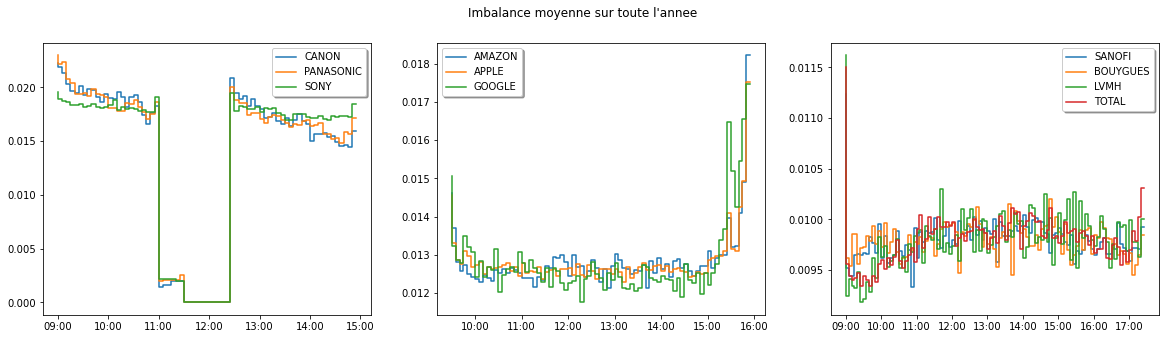

In [13]:
f, axs = plt.subplots(1, 3, figsize=(20,5))
f.suptitle("Imbalance moyenne sur toute l'annee")
for k, stocks in tqdm(allstocks.items()):
    index = pd.date_range(open_times[k], end=close_times[k], closed='left', freq="5Min")
    for stock in stocks:
        df_trades = pd.read_hdf(f'Data/{stock}.h5')
        df_trades.loc[:, "Imbalance"] = abs(df_trades.AskQty - df_trades.BidQty) / (df_trades.AskQty + df_trades.BidQty)
        df_trades_gb = df_trades.groupby(pd.Grouper(freq='5Min')).mean()
        tot = df_trades_gb.loc[:, "Imbalance"].sum()
        times = df_trades_gb.index
        df_trades_mean_by_year = df_trades_gb.groupby([times.hour, times.minute]).sum()
        np_trades_mean_by_year = np.zeros(shape=len(index))
        for i, t in enumerate(index):
            np_trades_mean_by_year[i] = df_trades_mean_by_year.loc[(t.hour, t.minute), 'Imbalance'] / tot
        axs[k].plot(index, np_trades_mean_by_year, label=f'{stock}',drawstyle='steps')
        axs[k].xaxis.set_major_formatter(date_form)
        axs[k].legend(shadow=True, fancybox=True)
plt.show()

```
Pour l'imbalance, les courbes sont differentes pour des differents marches. On reconnait la forme "U" inverse pour la bourse de Paris, forme "U" pour la bouse americaine, et le marche janponais a aussi deux forme "U". 
```

* Quantités aux best limits ($Q_{ask}+Q_{bid}$)

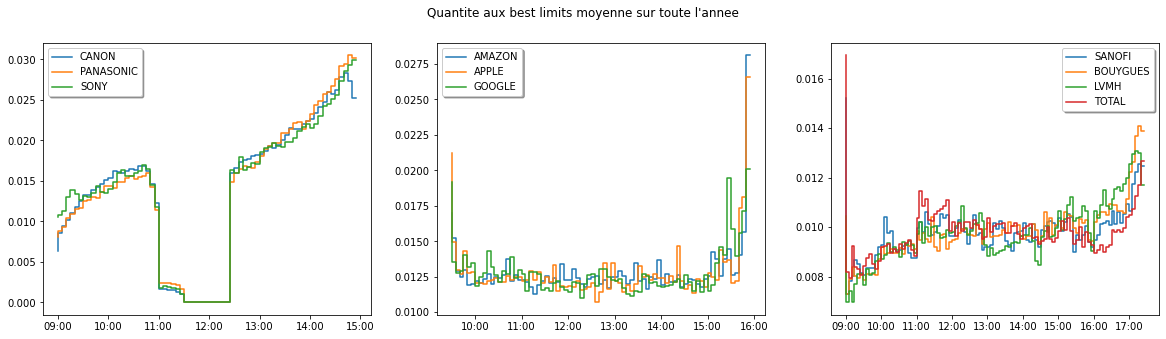

In [14]:
f, axs = plt.subplots(1, 3, figsize=(20,5))
f.suptitle("Quantite aux best limits moyenne sur toute l'annee")
for k, stocks in tqdm(allstocks.items()):
    index = pd.date_range(open_times[k], end=close_times[k], closed='left', freq="5Min")
    for stock in stocks:
        df_trades = pd.read_hdf(f'Data/{stock}.h5')
        df_trades.loc[:, "BestLimQty"] = df_trades.AskQty + df_trades.BidQty
        df_trades_gb = df_trades.groupby(pd.Grouper(freq='5Min')).mean()
        tot = df_trades_gb.loc[:, "BestLimQty"].sum()
        df_trades_mean_by_year = df_trades_gb.groupby([df_trades_gb.index.hour, df_trades_gb.index.minute]).sum()
        np_trades_mean_by_year = np.zeros(shape=len(index))
        for i, t in enumerate(index):
            np_trades_mean_by_year[i] = df_trades_mean_by_year.loc[(t.hour, t.minute), 'BestLimQty'] / tot
        axs[k].plot(index, np_trades_mean_by_year, label=f'{stock}',drawstyle='steps')
        axs[k].xaxis.set_major_formatter(date_form)
        axs[k].legend(shadow=True, fancybox=True)
plt.show()

```
Pour la quantite aux best limites: c'est la forme "J" pour le marché japonais et le marché américain. La bourse de Paris reconnaît une quantité très haute pendant les premières 5 minutes puis la quantité monte petit à petit. Le marché Nasdaq reconnaît une quantité haute surtout à la fermerture..
```

## III. Relation entre les indicateurs journaliers

### 1. Volume/trades et turnover/trades

Vous allez regarder maintenant la relation entre certains indicateurs journaliers à l'aide de régression linéaire :
* relation entre les volumes et les nombres de trades, 
* entre les turnovers et les nombres de trades, 
pour l'ensemble des actifs et commenterez les résultats obtenus.

### Reponse: 
* Relation entre les nombres de trades et les volumes

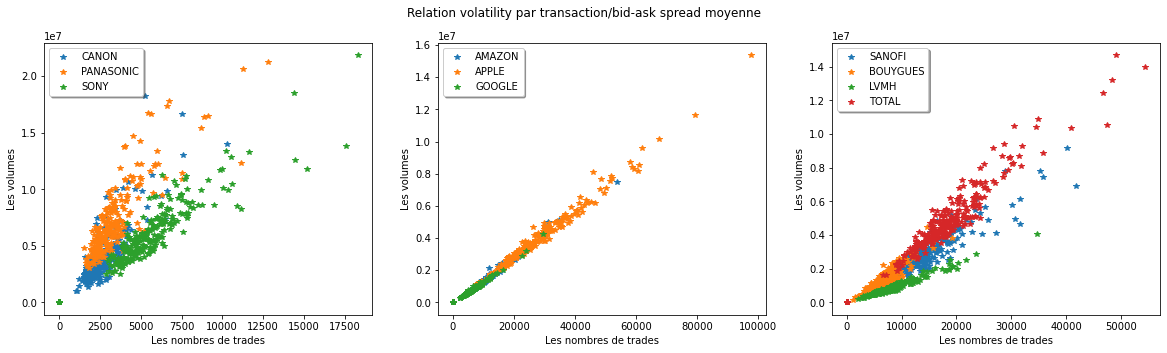

In [26]:
f, axs = plt.subplots(1, 3, figsize=(20,5))
f.suptitle("Relation volatility par transaction/bid-ask spread moyenne")
for k, stocks in tqdm(allstocks.items()):
    index = pd.date_range(open_times[k], end=close_times[k], closed='left', freq="5Min")
    for stock in stocks:
        df_trades = pd.read_hdf(f"Data/{stock}.h5") 
        x = df_trades['TradedQty'].resample('D').count()
        y = df_trades['TradedQty'].resample('D').sum()

        axs[k].plot(x, y, '*', label=f"{stock}")
        axs[k].legend(shadow=True, fancybox=True)
    axs[k].set_xlabel('Les nombres de trades')
    axs[k].set_ylabel('Les volumes')

* Relation entre les turnovers et les nombres de trades

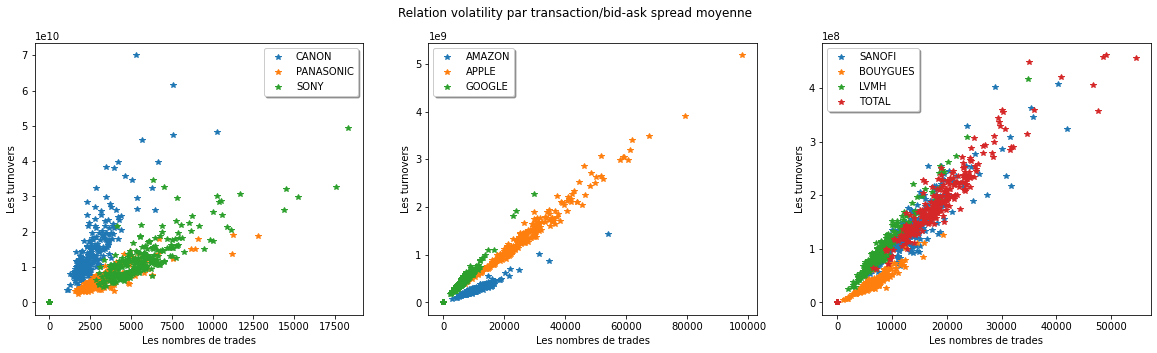

In [27]:
f, axs = plt.subplots(1, 3, figsize=(20,5))
f.suptitle("Relation volatility par transaction/bid-ask spread moyenne")
for k, stocks in tqdm(allstocks.items()):
    index = pd.date_range(open_times[k], end=close_times[k], closed='left', freq="5Min")
    for stock in stocks:
        df_trades = pd.read_hdf(f"Data/{stock}.h5") 
        x = df_trades['TradedQty'].resample('D').count()
        y = (df_trades['TradedQty'].multiply(df_trades['TradedPrice'])).resample('D').sum()

        axs[k].plot(x, y, '*', label=f"{stock}")
        axs[k].legend(shadow=True, fancybox=True)
    axs[k].set_xlabel('Les nombres de trades')
    axs[k].set_ylabel('Les turnovers')

```
On peut voir la relation linéaire entre les volumes et les nombres de trades et entre les turnovers et les nombres de trades, même les pentes sont différentes pour les actifs differents. Ces relations sont très fortes dans le marché Nasdaq et un peu moins fortes dans les bourses de Paris et de Japan.
```

### 2. Relation volatilité par transaction/bid-ask spread

La volatilité peut être considérée comme une mesure de la quantité d'information contenu dans un prix. En pratique, ces informations sont corrélées à un flux d'ordres qui anticipe ou provoque des changements de prix successifs.

Il est bien connu que le spread et la volatilité sont intimement liés: alors que le spread fixe le profit par transaction des market makers, la volatilité détermine la sélection adverse à laquelle ils doivent faire face.
Dans tout modèle où les market makers atteignent leur seuil de rentabilité, il faut avoir une équation fixant la relation entre le spread bid-ask et la volatilité.

Cette relation a fait l'objet de plusieurs modèles essayant de la justifier au niveau microscopique, alors que empiriquement cela a été analysé dans plusieurs travaux.
Dans le modèle le plus simple possible de Madhavan, Richardson et Roomans (MRR), on obtient que
$$\varphi=c\sigma_{mid} N^{-1/2},$$
où $\varphi$ est le spread bid-ask, $\sigma_{mid}$ est la volatilité du prix mid, $N$ le nombre de transactions et $c>0$.

**Implémentation sur les données.** Vous regarderez pour chaque actif la relation entre la volatilité par transaction journalière et le bid-ask spread journalier moyen. Commentez les résultats obtenus.

CANON: (5.200046750250822, 0.5060195152899334)
PANASONIC: (1.0472642448460523, 0.7471261714733808)
SONY: (1.2118601023537758, 0.8266873625578948)
AMAZON: (0.04595422028851158, 3.8509857568797976)
APPLE: (0.047016739088961694, 4.044738732499356)
GOOGLE: (0.20705375514452687, 2.858597652211725)
SANOFI: (0.012304276131267462, 2.4863289974683287)
BOUYGUES: (0.010064929584922935, 2.021473525539185)
LVMH: (0.06462983491386762, 1.346509682035048)
TOTAL: (0.008660566205420986, 1.6342295702334648)



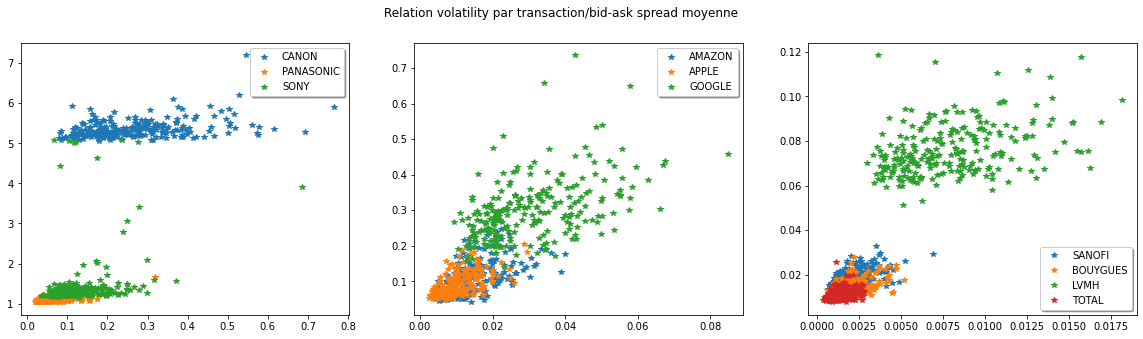

In [16]:
f, axs = plt.subplots(1, 3, figsize=(20,5))
f.suptitle("Relation volatility par transaction/bid-ask spread moyenne")
for k, stocks in tqdm(allstocks.items()):
    index = pd.date_range(open_times[k], end=close_times[k], closed='left', freq="5Min")
    for stock in stocks:
        df_trades = pd.read_hdf(f"Data/{stock}.h5")
        df_trades.loc[:, "Spread"] = abs(df_trades.loc[:, "AskPrice"] - df_trades.loc[:, "BidPrice"])
        
        df_trades_agg = df_trades.groupby(df_trades.index.date).agg(
            TradedCount=pd.NamedAgg(column="TradedQty", aggfunc="count"),
            Volatility=pd.NamedAgg(column="TradedPrice", aggfunc="var"),
            Spread=pd.NamedAgg(column="Spread", aggfunc="mean"))
        
        x = np.sqrt(df_trades_agg.Volatility / df_trades_agg.loc[:, "TradedCount"])
        y = df_trades_agg.Spread
        # regression lineaire robust
        x = sm.add_constant(x)
        # Fonction pour la régression de y sur x
        rlm_model = sm.RLM(y, x, M=sm.robust.norms.HuberT())
        model = rlm_model.fit()
        
        # Pour accéder aux coefficients
        print(f"{stock}: {model.params['const'], model.params[0]}")
        
        # df_trades_agg /= df_trades_agg.sum()
        axs[k].plot(np.sqrt(df_trades_agg.Volatility / df_trades_agg.loc[:, "TradedCount"]), df_trades_agg.Spread, '*', label=f"{stock}")
        axs[k].legend(shadow=True, fancybox=True)

```
Ici, nous avons utilisé robust linear regression pour éviter l'influence des outliers. 

À partir des graphes, nous constatons que les pentes sont plus ou moins proches pour les actifs du même marché. Puis, à partir des valeurs de pente calculées(deuxième chiffre des listes), les valeurs des pentes sont aussi proches. Nous ne pouvons pas dire que $c$ est pareil pour tous les actifs, mais nous pouvons dire que $c$ est proche pour les actifs du même marché.

En plus, sauf google et les actifs du marché japonais, les ordonnée à l'origine sont proches de 0. Le marché japanais est particulier pour son gros tick en 2011. 

Le modèle est donc vérifié par les données réelles.
```